In [1]:
import os
import sys
import json
import pickle
import pandas as pd
import scipy

import functools
import itertools
import yaml
import getopt
import numpy as np
import torch
from sklearn.metrics import f1_score, precision_score, recall_score, precision_recall_curve, auc
from sklearn.model_selection import train_test_split
from datetime import datetime
import copy
import matplotlib.pyplot as plt

from embedding import BertHuggingface
from salsa.SaLSA import SaLSA
from pie import BiasSpaceTransformer, CAVTransformer, PIE, DictionaryLearner, TransformerBackbone, Classifier, TorchPipelineForEmbeddings

# local imports
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..')))
import data_loader
import models
import utils

sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../../nullspace_projection/src/')))
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../../nullspace_projection/')))
import debias

2025-08-28 19:01:06.885971: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-28 19:01:06.896945: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-08-28 19:01:06.910053: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-08-28 19:01:06.913913: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-08-28 19:01:06.923786: I tensorflow/core/platform/cpu_feature_guar

In [2]:
CHECKPOINT_CBM_BIOS = '../../../artifacts/cbm_models/bios-supervised_text-embedding-3-small'
PARAM_FILE_CBM_BIOS = '../../../artifacts/cbm_models/bios-supervised_text-embedding-3-small.pickle'

EMB_DIR = '../../../artifacts/embeddings/'

DATASET1 = 'bios-supervised'
DATASET2 = 'bios-unsupervised'
LOCAL_DIR = '../../../data/bios_huggingface_merge.pkl'

MODEL_NAME = 'bert-base-uncased' #'text-embedding-3-small'
POOLING = 'mean'
BATCH_SIZE = 1

In [3]:
# defining terms for PIE
with open('configs/defining_terms.yaml', 'r') as ff:
    def_term_config = yaml.safe_load(ff)
defining_term_lookup = def_term_config['defining_terms']
group_match_lookup = def_term_config['group_matching']

defining_terms, g_def, n_protec, groups_pie = utils.get_multi_attr_def_terms_labels(defining_term_lookup)
attr_lbl = list(defining_term_lookup.keys())

In [4]:
# load the test data
dataset, emb_def_attr = utils.get_dataset_with_embeddings(EMB_DIR, DATASET1, MODEL_NAME, POOLING, BATCH_SIZE, LOCAL_DIR,
                                                          defining_term_dict=defining_terms)
_, emb_train, y_train, g_train, cw, gw = dataset.get_split('train')
_, emb_val, y_val, g_val, _, _ = dataset.get_split('dev')
X_test, emb_test, y_test, g_test, _, _ = dataset.get_split('test')

#dataset_big = utils.get_dataset_with_embeddings(EMB_DIR, DATASET2, MODEL_NAME, POOLING, BATCH_SIZE)
#X_test_big, emb_test_big, y_test_big, g_test_big, _, _ = dataset_big.get_split('test')

load BIOS with option supervised


A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Pl

compute class weights for split train
compute class weights for split test
compute class weights for split dev


/home/saschroeder/anaconda3/envs/pie/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Using Bert with CUDA/GPU
no optmizer specified, default to AdamW
embed train split...
load precomputed embeddings for train set
embed test split...
load precomputed embeddings for test set
embed dev split...
load precomputed embeddings for dev set


100%|█████████████████████████████████████████| 428/428 [00:13<00:00, 31.97it/s]


In [5]:
# load the pre-trained CBM (pretrained on BIOS supervised)
with open(PARAM_FILE_CBM_BIOS, "rb") as handle:
    model_params = pickle.load(handle)
hidden_size = model_params['clf']['hidden_size'] if 'hidden_size' in model_params['clf'].keys() else -1

print(model_params)

cbm = models.CBM(**model_params['clf'])
cbm.load_state_dict(torch.load(CHECKPOINT_CBM_BIOS, weights_only=True))
cbmWrapper = models.CBMWrapper(cbm, **model_params['wrapper'])

{'clf': {'n_concepts_unsup': 100, 'n_concepts_protec': 2, 'output_size': 10, 'input_size': 1536}, 'wrapper': {'lambda_concept': 0.5, 'optimizer': <class 'salsa.SaLSA.SaLSA'>, 'criterion': <class 'torch.nn.modules.loss.BCEWithLogitsLoss'>, 'lr': None, 'batch_size': 64}}
use a linear classifier


In [6]:
# create PIE
n_unsup = 200
n_concepts = n_protec + n_unsup
epochs = 50

clf = models.LinearClassifier(input_size=n_concepts, output_size=dataset.n_classes)
pipeline = TorchPipelineForEmbeddings(clf, n_concepts_protec=n_protec, n_concepts_unsup=n_unsup,
                                      remove_protected_features=False,
                                      optimizer=SaLSA, criterion=torch.nn.modules.loss.BCEWithLogitsLoss, 
                                      batch_size=64, class_weights=cw)

epochs = pipeline.fit_early_stopping(emb_protec=emb_def_attr, y_protec=g_def, emb_train=emb_train, y_train=y_train,
                                     emb_val=emb_val, y_val=y_val, attr_lbl=attr_lbl, group_lbl=groups_pie,
                                     max_epochs=epochs, delta=0.01, patience=10,)

use class weights
got a separate set of samples to fit the unsupervised concepts
at attribute: dialect
got only one group: compute group vector relative to neutral base
at attribute: disablity
got only one group: compute group vector relative to neutral base
at attribute: ethnicity
got 4 groups: compute 'any' vector and one for each group
at attribute: ethnicity2
got 8 groups: compute 'any' vector and one for each group
at attribute: gender
got 2 groups: compute 'any' vector and one for each group
at attribute: lgbtq
got 2 groups: compute 'any' vector and one for each group
at attribute: mental health
got only one group: compute group vector relative to neutral base
at attribute: race
got 3 groups: compute 'any' vector and one for each group
at attribute: religion
got 3 groups: compute 'any' vector and one for each group
at attribute: sexual orientation
got 3 groups: compute 'any' vector and one for each group
at attribute: trans/cis
got 2 groups: compute 'any' vector and one for each 

/home/saschroeder/anaconda3/envs/pie/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.013170242309570312, tolerance: 0.007225916720926762
  model = cd_fast.enet_coordinate_descent_gram(
/home/saschroeder/anaconda3/envs/pie/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008850255981087685, tolerance: 0.007300023455172777
  model = cd_fast.enet_coordinate_descent_gram(
/home/saschroeder/anaconda3/envs/pie/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008308851160109043, tolerance: 0.007383566815406084
  model = cd_fast.enet_coordinate_descent_gram(
/home/s

emb shape:  (7017, 768)
stopping after 13 epochs with validation loss 0.984


In [7]:
pred_cbm, concepts_cbm = cbmWrapper.predict(emb_test)
pred, concepts = pipeline.predict(emb_test, return_concepts=True, verbose=True)

y_pred = (pred >= 0.5).astype(int)
f1 = f1_score(y_test, y_pred, average='macro')
f1

RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x768 and 1536x2)

In [ ]:
print("dataset group and CBM concept label: ")
print(dataset.group_names)
print()
print("pie groups: ")
print(pipeline.group_lbl)

# female / male ids for dataset and CBM
fid = dataset.group_names.index('female')
mid = dataset.group_names.index('male')

# gender(any) / female / male ids for PIE
gid_pie = pipeline.group_lbl.index('gender:any')
fid_pie = pipeline.group_lbl.index('gender:female')
mid_pie = pipeline.group_lbl.index('gender:male')

## Failure cases and extreme cases of PIE and CBM

There are hardly any failure cases, but since we know that BIOS includes out-of-domain samples (without gender info) it could be interesting to see if failure cases are explained by them.

In [10]:
# PIE lowest/ highest gender score
ids_pie = np.argsort(concepts[:, gid_pie])
ids_pie_b = np.argsort(concepts_b[:, gid_pie])

print("5 lowest gender scores (PIE, bios-supervised):")
for idx in ids_pie[:5]:
    g_lbl = g_test[idx].astype('int')
    print(dataset.group_names[g_lbl[1]], concepts[idx, [fid_pie, mid_pie, gid_pie]], '\t', X_test[idx])

print()
print("5 lowest gender scores (PIE, bios-unsupervised):")
for idx in ids_pie_b[:5]:
    g_lbl = g_test_big[idx].astype('int')
    print(dataset.group_names[g_lbl[1]], concepts_b[idx, [fid_pie, mid_pie, gid_pie]], '\t', X_test_big[idx])
    print(concepts_cbm_b[idx, :])

5 lowest gender scores (PIE, bios-supervised):
female [-0.02577433 -0.0813475  -0.08737345] 	 A psychologist focuses on the evaluation, prevention, diagnosis, and treatment of mental, emotional and behavioral health issues. A clinical psychologist uses psychotherapy and other counseling skills to improve emotional and mental health.
female [ 0.07459054 -0.17646743 -0.08474508] 	 She describes their partnership as helpful for students. “This is a tremendous resource,” Thede comments, “offering a higher level of intervention than the school nurse is licensed to provide.”
female [ 0.01868393 -0.11323371 -0.0778088 ] 	 In Paris in 2004, the book called: Artek, un été en Crimée (Artek, a summer in Crimea, Ukraine) of Claudine was published.The pictures were taken from 1994 until 2003. There are no boring staged or formal photos. All images of Claudine show the true story about the Artek life of children in there. Some people found the photos absolutely delightful, others subjected them to d

In [26]:
ids = np.argsort(np.sum(np.abs(concepts_cbm), axis=1))
ids_b = np.argsort(np.sum(np.abs(concepts_cbm_b), axis=1))

print("samples with lowest gender scores (M+F) for CBM on bios-supervised:")
for idx in ids[:5]:
    g_lbl = g_test[idx].astype('int')
    print(dataset.group_names[g_lbl[1]], concepts_cbm[idx, :], '\t', X_test[idx])

print()
print("samples with lowest gender scores (M+F) for CBM on bios-unsupervised:")
for idx in ids_b[:5]:
    g_lbl = g_test_big[idx].astype('int')
    print(dataset.group_names[g_lbl[1]], concepts_cbm_b[idx, :], '\t', X_test_big[idx])
    print(concepts_b[idx, [fid_pie, mid_pie, gid_pie]])

samples with lowest gender scores (M+F) for CBM on bios-supervised:
male [ 0.1442031  -0.15843192] 	 British fashion and portrait photographer focused on older women with individual character and extraordinary appearance. For Anthony, London has a select group of fabulous creatures that are loyal to themselves, to their own style and this is reflected in the streets he has chosen to work in. Lycett exceptional imagery takes classic portraiture to an other level, creating images that raise an eyebrow or spark a smile.
male [-0.39165732  0.39876178] 	 Dr. Bonnen holds a Bachelor of Science degree from Texas A&M University and an M.D. from the University of Texas Medical Branch in Galveston, Texas. He and his wife, Kim, have two daughters.
male [-0.40298375  0.4831492 ] 	 Dale Porno Te damos la bienvenida al portal n°1 de fotos xxx de internet. He arranged for a meeting between Sunny and Jay Allen, who was a photographer for Penthouse. Pakistanisch-filme Sexy Dessous Bollywood Hot Girls B

In [27]:
pie_lbl_diff = g_test[:,fid] - concepts[:,fid_pie]
ids = np.argsort(pie_lbl_diff)

print("PIE top 10 mistakes")
for idx in ids[-10:]:
    print(g_test[idx,fid], concepts[idx,fid_pie], X_test[idx])

PIE top 10 mistakes
1.0 0.042907197 Her husband Jack is an ambitious and confident sports presenter for a television company. They live, comfortably and pleasantly, with their two existing children, in an affluent district beside the River Thames, a district so full of delis, bookshops, fine restaurants and boutiques that the residents, rightfully smug about their little enclave, have added the word ‘Village’ to the perfectly acceptable name by which it has been known since being recorded in The Domesday Book.
1.0 0.03854976 She has been covering NATO and European security and foreign policy issues both during and after the Cold War. “Trump’s comments that NATO allies, Europeans in particular, have to pay their fair share, that’s true,” Dempsey told Euronews. “But frankly it’s nothing new. “Successive American administrations have said the same thing. And actually since the Russian invasion of Crimea, and in Eastern Ukraine, the Europeans are improving a little. “As for NATO being obso

In [13]:
ids_m = np.where(g_test[:,mid]==1)[0]
ids_f =np.where(g_test[:,fid]==1)[0]
X_test_m = [X_test[idx] for idx in ids_m]
X_test_f = [X_test[idx] for idx in ids_f]

sort_ids_m = np.argsort(concepts_cbm[ids_m,mid])
sort_ids_f = np.argsort(concepts_cbm[ids_f,fid])

print("CBM top 10 mistakes (M)")
for idx in sort_ids_m[:10]:
    print(cbm_m[idx], X_test_m[idx])

print()
print("CBM top 10 mistakes (F)")
for idx in sort_ids_f[:10]:
    print(cbm_f[idx], X_test_f[idx])

CBM top 10 mistakes (M)


NameError: name 'cbm_m' is not defined

## Exploring other protected groups

Identify possible other protected groups in the dataset via PIE/ CBM concepts.

In [ ]:
for idx, group in enumerate(pipeline.group_lbl):
    print(group)
    c = concepts[:, idx]
    ids = np.argsort(c)
    for i in ids[-5:]:
        print(X_test[i])

    print()

# Debiasing experiments

Compare baseline (no debias) and two debiasing methods from literature against 'fairness through awareness' approach with PIE (bias space and CAV).
Maybe use a subset or only consider well represented groups to make re-balancing feasible.

In [ ]:
def compute_TPR_GAP(y_test, y_pred, g_test):
    n_groups = g_test.shape[1]
    n_classes = y_test.shape[1]
    tpr_scores = np.zeros((n_groups, n_classes))
    for group in range(n_groups):
        y_test_ = y_test[g_test[:, group] == 1]
        y_pred_ = y_pred[g_test[:, group] == 1]
        for class_id in range(n_classes):
            y_pred_true = y_pred_[y_test_[:, class_id] == 1, class_id]
            tpr_scores[group, class_id] = np.mean(y_pred_true)

    if n_groups == 2:
        print("return binary TPR GAP (group 1 - group 0):")
        return tpr_scores[1, :] - tpr_scores[0, :]
    else:
        print("return multi-group TPR GAP (standard deviation between groups):")
        return np.std(tpr_scores, axis=0)

def plot_tpr(tpr_scores, class_names, title, ylabel):
    fig, ax = plt.subplots()
    x = np.arange(len(tpr_scores))
    ax.bar(x, tpr_scores)
    ax.set_xticks(x, class_names, rotation=90)
    
    ax.set_title(title)
    ax.set_ylabel(ylabel)

    plt.show()

### Baseline: Classifier trained on embeddings without debiasing

In [ ]:
def train_baseline(emb_train, y_train, g_train, emb_val, y_val, g_val, emb_test, y_test, g_test, plot=False):
    clf_base = models.LinearClassifier(input_size=emb_test.shape[1], output_size=dataset.n_classes)
    wrapper = models.ClfWrapper(clf_base, batch_size=64, class_weights=cw, criterion=torch.nn.BCEWithLogitsLoss, optimizer=SaLSA)
    wrapper.fit_early_stopping(emb_train, y_train, emb_val, y_val, max_epochs=50, delta=0.0, patience=10, verbose=False)
    pred = wrapper.predict(emb_test)
    y_pred = (pred >= 0.5).astype(int)
    
    f1 = f1_score(y_test, y_pred, average='macro')
    rec = recall_score(y_test, y_pred, average='macro')
    prec = precision_score(y_test, y_pred, average='macro')
    tpr_scores = compute_TPR_GAP(y_test, y_pred, g_test)
    mean_gap = np.mean(np.abs(tpr_scores))
    print("mean abs TPR GAP: %.3f" % mean_gap)

    if plot:
        plot_tpr(tpr_scores, dataset.class_names, 'Baseline (GAP=%.3f, F1=%.3f)' % (mean_gap, f1), ylabel='TPR(F) - TPR(M)')

    return f1, prec, rec, mean_gap, tpr_scores

def train_baseline_mlp(emb_train, y_train, g_train, emb_val, y_val, g_val, emb_test, y_test, g_test, plot=False):
    clf_base = models.MLP2Layer(input_size=emb_test.shape[1], hidden_size=emb_test.shape[1], output_size=dataset.n_classes)
    wrapper = models.ClfWrapper(clf_base, batch_size=64, class_weights=cw, criterion=torch.nn.BCEWithLogitsLoss, optimizer=SaLSA)
    wrapper.fit_early_stopping(emb_train, y_train, emb_val, y_val, max_epochs=50, delta=0.0, patience=10, verbose=False)
    pred = wrapper.predict(emb_test)
    y_pred = (pred >= 0.5).astype(int)
    
    f1 = f1_score(y_test, y_pred, average='macro')
    rec = recall_score(y_test, y_pred, average='macro')
    prec = precision_score(y_test, y_pred, average='macro')
    tpr_scores = compute_TPR_GAP(y_test, y_pred, g_test)
    mean_gap = np.mean(np.abs(tpr_scores))
    print("mean abs TPR GAP: %.3f" % mean_gap)

    if plot:
        plot_tpr(tpr_scores, dataset.class_names, 'Baseline (GAP=%.3f, F1=%.3f)' % (mean_gap, f1), ylabel='TPR(F) - TPR(M)')

    return f1, prec, rec, mean_gap, tpr_scores

train_baseline(emb_train, y_train, g_train, emb_val, y_val, g_val, emb_test, y_test, g_test, plot=True)
train_baseline_mlp(emb_train, y_train, g_train, emb_val, y_val, g_val, emb_test, y_test, g_test, plot=True)

In [ ]:
f1s = []
gaps = []
precs = []
recs = []
for i in range(10):
    f1, prec, rec, gap, _ = train_baseline(emb_train, y_train, g_train, emb_val, y_val, g_val, emb_test, y_test, g_test)
    f1s.append(f1)
    precs.append(prec)
    recs.append(rec)
    gaps.append(gap)

print("GAP = %.3f +/- %.3f" % (np.mean(gaps), np.std(gaps)))
print("F1 = %.3f +/- %.3f" % (np.mean(f1s), np.std(f1s)))
print("Precision = %.3f +/- %.3f" % (np.mean(precs), np.std(precs)))
print("Recall = %.3f +/- %.3f" % (np.mean(recs), np.std(recs)))

In [12]:
print("GAP = %.3f +/- %.3f" % (np.mean(gaps), np.std(gaps)))
print("F1 = %.3f +/- %.3f" % (np.mean(f1s), np.std(f1s)))

GAP = 0.134 +/- 0.009
F1 = 0.828 +/- 0.002


In [157]:
f1s = []
gaps = []
precs = []
recs = []
for i in range(10):
    f1, prec, rec, gap, _ = train_baseline_mlp(emb_train, y_train, g_train, emb_val, y_val, g_val, emb_test, y_test, g_test)
    f1s.append(f1)
    precs.append(prec)
    recs.append(rec)
    gaps.append(gap)

print("GAP = %.3f +/- %.3f" % (np.mean(gaps), np.std(gaps)))
print("F1 = %.3f +/- %.3f" % (np.mean(f1s), np.std(f1s)))
print("Precision = %.3f +/- %.3f" % (np.mean(precs), np.std(precs)))
print("Recall = %.3f +/- %.3f" % (np.mean(recs), np.std(recs)))

use class weights
stopping after 14 epochs with validation loss 0.959
return binary TPR GAP (group 1 - group 0):
mean abs TPR GAP: 0.140
use class weights
stopping after 12 epochs with validation loss 0.960
return binary TPR GAP (group 1 - group 0):
mean abs TPR GAP: 0.134
use class weights
stopping after 12 epochs with validation loss 0.959
return binary TPR GAP (group 1 - group 0):
mean abs TPR GAP: 0.139
use class weights
stopping after 12 epochs with validation loss 0.959
return binary TPR GAP (group 1 - group 0):
mean abs TPR GAP: 0.142
use class weights
stopping after 12 epochs with validation loss 0.959
return binary TPR GAP (group 1 - group 0):
mean abs TPR GAP: 0.137
use class weights
stopping after 14 epochs with validation loss 0.960
return binary TPR GAP (group 1 - group 0):
mean abs TPR GAP: 0.139
use class weights
stopping after 14 epochs with validation loss 0.958
return binary TPR GAP (group 1 - group 0):
mean abs TPR GAP: 0.145
use class weights
stopping after 13 epoch

### Debiasing Baseline 1: Iterative Nullspace Projection

In [31]:
# gender ratio in train and validation set (baseline)
np.mean(g_train[:,0])

0.5734644434943709

In [32]:
np.mean(g_val[:,0])

0.5783938814531548

In [162]:
import time
from sklearn.linear_model import SGDClassifier, SGDRegressor, Perceptron, LogisticRegression, LinearRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import r2_score

# cannot deal with multi label for Y_task
def get_projection_matrix(num_clfs, X_train, Y_train_gender, X_dev, Y_dev_gender, Y_train_task=None, Y_dev_task=None, 
                          dim=300, clf_type="svm"):

    is_autoregressive = True
    min_acc = 0.
    #noise = False
    dim = X_train.shape[1]
    n = num_clfs
    #random_subset = 1.0
    start = time.time()

    #x_train_gender = x_train.copy()
    #x_dev_gender = x_dev.copy()   
    
    if clf_type == "sgd":
        gender_clf = SGDClassifier
        params = {'loss': 'hinge', 'penalty': 'l2', 'fit_intercept': False, 'class_weight': None, 'n_jobs': 32}
    elif clf_type == "svm":
        gender_clf = LinearSVC
        params = {'penalty': 'l2', 'C': 0.01, 'fit_intercept': True, 'class_weight': None, "dual": False}
    elif clf_type == "regression":
        gender_clf = LinearRegression
        params = {'fit_intercept': True}

    by_class = (Y_train_task is not None and Y_dev_task is not None)
    P,rowspace_projections, Ws = debias.get_debiasing_projection(gender_clf, params, n, dim, is_autoregressive, min_acc,
                                              X_train, Y_train_gender, X_dev, Y_dev_gender,
                                       Y_train_main=Y_train_task, Y_dev_main=Y_dev_task, by_class = by_class)
    print("time: {}".format(time.time() - start))
    return P,rowspace_projections, Ws

def debias_inlp(emb_train, y_train, g_train, emb_val, y_val, g_val, emb_test, y_test, g_test,
                n_iter=4, dim=500, clf_type="svm", use_mlp=False, plot=False):
    P,rowspace_projections, Ws = get_projection_matrix(n_iter, emb_train, g_train[:,0], emb_val, g_val[:,0], dim=dim, clf_type=clf_type)

    P_rowspace = np.eye(emb_train.shape[1]) - P
    mean_gender_vec = np.mean(P_rowspace.dot(emb_train.T).T, axis = 0)
    
    emb_train_ = P.dot(emb_train.T).T.astype('float32')
    emb_val_ = P.dot(emb_val.T).T.astype('float32')
    emb_test_ = P.dot(emb_test.T).T.astype('float32')

    # gender reconstruction
    if clf_type == "regression":
        clf = LinearRegression()
        clf.fit(emb_train_, g_train[:,0])
        score = r2_score(g_test[:,0], clf.predict(emb_test_))
    else:
        clf = LogisticRegression()
        clf.fit(emb_train_, g_train[:,0])
        score = roc_auc_score(g_test[:,0], clf.predict_proba(emb_test_)[:, 1])

    if use_mlp:
        return train_baseline_mlp(emb_train_, y_train, g_train, emb_val_, y_val, g_val, emb_test_, y_test, g_test, plot=plot)
    else:
        return train_baseline(emb_train_, y_train, g_train, emb_val_, y_val, g_val, emb_test_, y_test, g_test, plot=plot)

iteration: 4, accuracy: 0.5783938814531548: 100%|█| 5/5 [00:08<00:00,  1.63s/it]


time: 8.786346673965454
use class weights
stopping after 14 epochs with validation loss 0.971
return binary TPR GAP (group 1 - group 0):
mean abs TPR GAP: 0.109


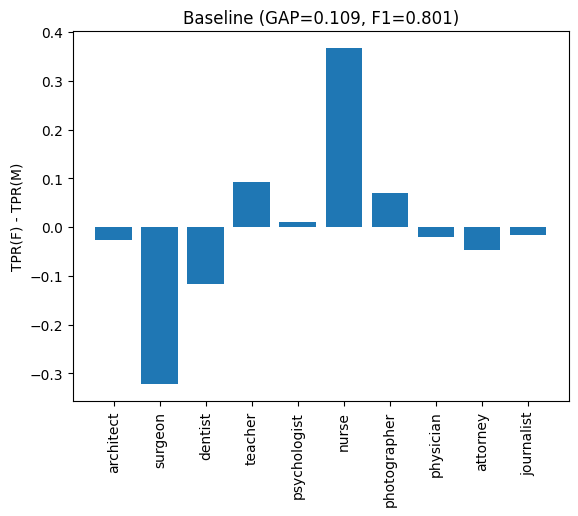

(0.8007771046721588,
 0.7758162985049757,
 0.8289834704120324,
 0.10886979704469021,
 array([-0.02607562, -0.3222285 , -0.11695906,  0.09150755,  0.01031022,
         0.36672851,  0.06936017, -0.02052206, -0.04783815, -0.01716814]))

In [163]:
debias_inlp(emb_train, y_train, g_train, emb_val, y_val, g_val, emb_test, y_test, g_test, n_iter=5, dim=500, plot=True)

In [165]:
f1s = []
precs = []
recs = []
gaps = []
for i in range(10):
    f1, prec, rec, gap, _ = debias_inlp(emb_train, y_train, g_train, emb_val, y_val, g_val, emb_test, y_test, g_test, n_iter=5, dim=500)
    precs.append(prec)
    recs.append(rec)
    f1s.append(f1)
    gaps.append(gap)

print("GAP = %.3f +/- %.3f" % (np.mean(gaps), np.std(gaps)))
print("F1 = %.3f +/- %.3f" % (np.mean(f1s), np.std(f1s)))
print("Precision = %.3f +/- %.3f" % (np.mean(precs), np.std(precs)))
print("Recall = %.3f +/- %.3f" % (np.mean(recs), np.std(recs)))

iteration: 4, accuracy: 0.5783938814531548: 100%|█| 5/5 [00:08<00:00,  1.74s/it]


time: 9.36557388305664
use class weights
stopping after 16 epochs with validation loss 0.970
return binary TPR GAP (group 1 - group 0):
mean abs TPR GAP: 0.093


iteration: 4, accuracy: 0.5783938814531548: 100%|█| 5/5 [00:08<00:00,  1.74s/it]


time: 9.32626986503601
use class weights
stopping after 14 epochs with validation loss 0.974
return binary TPR GAP (group 1 - group 0):
mean abs TPR GAP: 0.103


iteration: 4, accuracy: 0.5783938814531548: 100%|█| 5/5 [00:09<00:00,  1.93s/it]


time: 10.95237112045288
use class weights
stopping after 13 epochs with validation loss 0.973
return binary TPR GAP (group 1 - group 0):
mean abs TPR GAP: 0.095


iteration: 4, accuracy: 0.5783938814531548: 100%|█| 5/5 [00:08<00:00,  1.73s/it]


time: 9.278573274612427
use class weights
stopping after 13 epochs with validation loss 0.973
return binary TPR GAP (group 1 - group 0):
mean abs TPR GAP: 0.101


iteration: 4, accuracy: 0.5783938814531548: 100%|█| 5/5 [00:08<00:00,  1.62s/it]


time: 8.696196556091309
use class weights
stopping after 12 epochs with validation loss 0.972
return binary TPR GAP (group 1 - group 0):
mean abs TPR GAP: 0.104


iteration: 4, accuracy: 0.5783938814531548: 100%|█| 5/5 [00:08<00:00,  1.72s/it]


time: 9.275240182876587
use class weights
stopping after 16 epochs with validation loss 0.972
return binary TPR GAP (group 1 - group 0):
mean abs TPR GAP: 0.101


iteration: 4, accuracy: 0.5783938814531548: 100%|█| 5/5 [00:08<00:00,  1.64s/it]


time: 9.02920389175415
use class weights
stopping after 15 epochs with validation loss 0.971
return binary TPR GAP (group 1 - group 0):
mean abs TPR GAP: 0.106


iteration: 4, accuracy: 0.5783938814531548: 100%|█| 5/5 [00:08<00:00,  1.78s/it]


time: 9.49394941329956
use class weights
stopping after 15 epochs with validation loss 0.970
return binary TPR GAP (group 1 - group 0):
mean abs TPR GAP: 0.103


iteration: 4, accuracy: 0.5783938814531548: 100%|█| 5/5 [00:08<00:00,  1.64s/it]


time: 8.814983367919922
use class weights
stopping after 17 epochs with validation loss 0.973
return binary TPR GAP (group 1 - group 0):
mean abs TPR GAP: 0.110


iteration: 4, accuracy: 0.5783938814531548: 100%|█| 5/5 [00:08<00:00,  1.62s/it]


time: 8.806461095809937
use class weights
stopping after 17 epochs with validation loss 0.974
return binary TPR GAP (group 1 - group 0):
mean abs TPR GAP: 0.110
GAP = 0.102 +/- 0.005
F1 = 0.800 +/- 0.004
Precision = 0.778 +/- 0.010
Recall = 0.826 +/- 0.005


In [166]:
f1s = []
precs = []
recs = []
gaps = []
for i in range(10):
    f1, prec, rec, gap, _ = debias_inlp(emb_train, y_train, g_train, emb_val, y_val, g_val, emb_test, y_test, g_test, n_iter=5, dim=500, use_mlp=True)
    precs.append(prec)
    recs.append(rec)
    f1s.append(f1)
    gaps.append(gap)

print("GAP = %.3f +/- %.3f" % (np.mean(gaps), np.std(gaps)))
print("F1 = %.3f +/- %.3f" % (np.mean(f1s), np.std(f1s)))
print("Precision = %.3f +/- %.3f" % (np.mean(precs), np.std(precs)))
print("Recall = %.3f +/- %.3f" % (np.mean(recs), np.std(recs)))

iteration: 4, accuracy: 0.5783938814531548: 100%|█| 5/5 [00:08<00:00,  1.67s/it]


time: 8.935654878616333
use class weights
stopping after 13 epochs with validation loss 0.966
return binary TPR GAP (group 1 - group 0):
mean abs TPR GAP: 0.120


iteration: 4, accuracy: 0.5783938814531548: 100%|█| 5/5 [00:08<00:00,  1.62s/it]


time: 8.738313913345337
use class weights
stopping after 13 epochs with validation loss 0.966
return binary TPR GAP (group 1 - group 0):
mean abs TPR GAP: 0.108


iteration: 4, accuracy: 0.5783938814531548: 100%|█| 5/5 [00:07<00:00,  1.57s/it]


time: 8.43234634399414
use class weights
stopping after 15 epochs with validation loss 0.965
return binary TPR GAP (group 1 - group 0):
mean abs TPR GAP: 0.103


iteration: 4, accuracy: 0.5783938814531548: 100%|█| 5/5 [00:08<00:00,  1.60s/it]


time: 8.631750106811523
use class weights
stopping after 13 epochs with validation loss 0.965
return binary TPR GAP (group 1 - group 0):
mean abs TPR GAP: 0.124


iteration: 4, accuracy: 0.5783938814531548: 100%|█| 5/5 [00:07<00:00,  1.55s/it]


time: 8.388858556747437
use class weights
stopping after 13 epochs with validation loss 0.963
return binary TPR GAP (group 1 - group 0):
mean abs TPR GAP: 0.117


iteration: 4, accuracy: 0.5783938814531548: 100%|█| 5/5 [00:07<00:00,  1.54s/it]


time: 8.334108829498291
use class weights
stopping after 14 epochs with validation loss 0.965
return binary TPR GAP (group 1 - group 0):
mean abs TPR GAP: 0.109


iteration: 4, accuracy: 0.5783938814531548: 100%|█| 5/5 [00:08<00:00,  1.62s/it]


time: 8.758756399154663
use class weights
stopping after 12 epochs with validation loss 0.965
return binary TPR GAP (group 1 - group 0):
mean abs TPR GAP: 0.118


iteration: 4, accuracy: 0.5783938814531548: 100%|█| 5/5 [00:08<00:00,  1.60s/it]


time: 8.615453720092773
use class weights
stopping after 14 epochs with validation loss 0.968
return binary TPR GAP (group 1 - group 0):
mean abs TPR GAP: 0.129


iteration: 4, accuracy: 0.5783938814531548: 100%|█| 5/5 [00:07<00:00,  1.60s/it]


time: 8.604103565216064
use class weights
stopping after 12 epochs with validation loss 0.964
return binary TPR GAP (group 1 - group 0):
mean abs TPR GAP: 0.112


iteration: 4, accuracy: 0.5783938814531548: 100%|█| 5/5 [00:07<00:00,  1.55s/it]


time: 8.357049942016602
use class weights
stopping after 15 epochs with validation loss 0.966
return binary TPR GAP (group 1 - group 0):
mean abs TPR GAP: 0.111
GAP = 0.115 +/- 0.007
F1 = 0.834 +/- 0.003
Precision = 0.840 +/- 0.005
Recall = 0.833 +/- 0.003


iteration: 0, accuracy: 0.9961759082217974: 100%|█| 1/1 [00:01<00:00,  1.88s/it]


time: 2.4825241565704346
use class weights
stopping after 14 epochs with validation loss 0.960
return binary TPR GAP (group 1 - group 0):


iteration: 1, accuracy: 0.6491395793499044: 100%|█| 2/2 [00:03<00:00,  1.67s/it]


time: 3.97102952003479
use class weights
stopping after 13 epochs with validation loss 0.965
return binary TPR GAP (group 1 - group 0):


iteration: 2, accuracy: 0.5812619502868069: 100%|█| 3/3 [00:05<00:00,  1.70s/it]


time: 5.721147775650024
use class weights
stopping after 13 epochs with validation loss 0.966
return binary TPR GAP (group 1 - group 0):


iteration: 3, accuracy: 0.5783938814531548: 100%|█| 4/4 [00:07<00:00,  1.78s/it]


time: 8.091770887374878
use class weights
stopping after 12 epochs with validation loss 0.968
return binary TPR GAP (group 1 - group 0):


iteration: 4, accuracy: 0.5783938814531548: 100%|█| 5/5 [00:08<00:00,  1.64s/it]


time: 8.843709230422974
use class weights
stopping after 12 epochs with validation loss 0.972
return binary TPR GAP (group 1 - group 0):


iteration: 5, accuracy: 0.5783938814531548: 100%|█| 6/6 [00:09<00:00,  1.57s/it]


time: 10.008274793624878
use class weights
stopping after 15 epochs with validation loss 0.975
return binary TPR GAP (group 1 - group 0):


iteration: 6, accuracy: 0.5783938814531548: 100%|█| 7/7 [00:11<00:00,  1.61s/it]


time: 11.908111333847046
use class weights
stopping after 16 epochs with validation loss 0.981
return binary TPR GAP (group 1 - group 0):


iteration: 7, accuracy: 0.5783938814531548: 100%|█| 8/8 [00:12<00:00,  1.51s/it]


time: 12.798228740692139
use class weights
stopping after 14 epochs with validation loss 0.984
return binary TPR GAP (group 1 - group 0):


iteration: 8, accuracy: 0.5783938814531548: 100%|█| 9/9 [00:13<00:00,  1.53s/it]


time: 14.351333141326904
use class weights
stopping after 19 epochs with validation loss 0.991
return binary TPR GAP (group 1 - group 0):


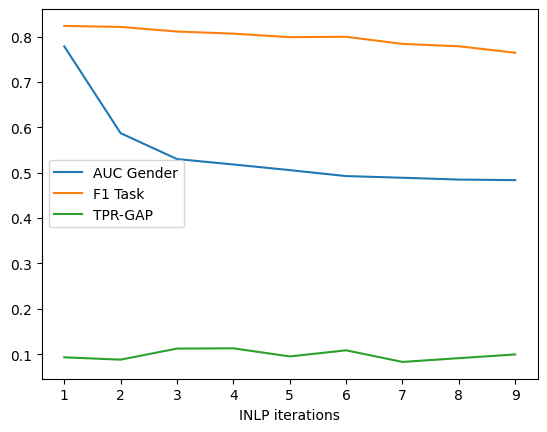

In [42]:
from sklearn.metrics import roc_auc_score

f1s = []
gaps = []
gender_aucs = []
iterations = list(range(1,10))
dim = 500
for i in iterations:
    f1, prec, rec, gap, _, auc = debias_inlp(emb_train, y_train, g_train, emb_val, y_val, g_val, emb_test, y_test, g_test, n_iter=i, dim=500)
    gaps.append(gap)
    f1s.append(f1)
    gender_aucs.append(auc)

fig, ax = plt.subplots()
ax.plot(iterations, gender_aucs, label='AUC Gender')
ax.plot(iterations, f1s, label='F1 Task')
ax.plot(iterations, gaps, label='TPR-GAP')
ax.legend()
ax.set_xlabel('INLP iterations')
plt.show()

### Debiasing Baseline 2: Re-balancing data based on dataset labels

In [18]:
def sort_classes_by_overlap(y: np.ndarray):
    # sort multi label classes by their overlap (most overlap first, more unique classes last)
    n_classes = y.shape[1]

    overlaps = np.zeros((n_classes, n_classes))
    for i in range(n_classes):
        for j in range(n_classes):
            inter = np.logical_and(y[:, i], y[:, j]).sum()
            union = np.logical_or(y[:, i], y[:, j]).sum()
            overlaps[i, j] = inter / union if union > 0 else 0.0

    overlap_scores = overlaps.sum(axis=1) - np.diag(overlaps)
    sort_idx = np.argsort(-overlap_scores)

    return sort_idx, overlap_scores


def resample_multi_label(X: np.ndarray, y: np.ndarray, samples_per_group: int):
    """
    X : ndarray, input features
    y : ndarray, class label (onehot encoded multi-label)
    samples_per_group : number of samples per subgroup to return
    """
    n_classes = y.shape[1]
    y_unique = np.arange(y.shape[1])
    subgroup_indices = {cls: np.where(y[:, cls] == 1)[0] for cls in y_unique}

    # could use this to start with overlapping classes
    #sort_idx, overlaps = sort_classes_by_overlap(y)
    #print("overlap:")
    #print(sort_idx)
    #print(overlaps)
    
    cls_done = []
    X_res = []
    y_res = []
    for cls, indices in subgroup_indices.items():
        if len(indices) == 0:
            continue
            
        # remove samples that also contain one of the previous classes to prevent over-sampling any class
        for cls_ in cls_done:
            indices = [idx for idx in indices if not y[idx, cls_] == 1]
        if len(indices) == 0:
            print("ERROR: got no indices after removing samples from previous classes")

        # and adapt number of samples to draw (there might already be samples in the new set from last draws
        if len(y_res) > 0:
            cur_samples_to_draw = int(samples_per_group - np.sum(np.array(y_res)[:, cls]))
        else:
            cur_samples_to_draw = samples_per_group
        
        sampled_ids = np.random.choice(indices, size=cur_samples_to_draw, replace=True)
        X_res += [X[idx, :] for idx in sampled_ids]
        y_res += [y[idx, :] for idx in sampled_ids]
        cls_done.append(cls)
    
    return np.array(X_res), np.array(y_res)

def fair_resample(X: np.ndarray, y: np.ndarray, s: np.ndarray, n_new_samples : int):
    n_samples = X.shape[0]
    
    # determine if y and/or s are multi-label and all possible classes/ groups
    y_multi_label = (y.ndim > 1 and y.shape[1] > 1)
    s_multi_label = (s.ndim > 1 and s.shape[1] > 1)
    s_unique = np.arange(s.shape[1]) if s_multi_label else np.unique(s)
    y_unique = np.arange(y.shape[1]) if y_multi_label else np.unique(y)
    
    # create auxiliary labels for all possible pairwise combinations of one class with one group
    # or one class and all groups=0 / one group and all classes=0
    # and transform to multi-labels
    subgroups = [(cls, grp) for cls in y_unique for grp in s_unique]+[(cls, -1) for cls in y_unique]+[(-1, grp) for grp in s_unique]
    #print(subgroups)
    assert n_new_samples > len(subgroups), "ERROR: got more subgroups than the number samples to be generated!"
    
    y_sub = np.zeros((n_samples, len(subgroups)))
    for idx in range(n_samples):
        # get all pairwise combinations of positive class/group labels of this sample
        class_ids = np.where(y[idx, :] == 1)[0]
        group_ids = np.where(s[idx, :] == 1)[0]

        if len(class_ids) == 0:
            pairs = [(-1, grp) for grp in group_ids]
        elif len(group_ids) == 0:
            pairs = [(cls, -1) for cls in class_ids]
        else:
            pairs = [(cls, grp) for cls in class_ids for grp in group_ids]
            
        for (cls, grp) in pairs:
            sub_idx = subgroups.index((cls, grp))
            y_sub[idx, sub_idx] = 1

    #print("number of samples per subgroup:")
    #print(np.sum(y_sub, axis=0))
    
    # in case some combinations do not exist, adapt the number of subgroups and samples per subgroup
    n_subgroups_exist = len(np.where(np.sum(y_sub, axis=0) > 0)[0])
    if n_subgroups_exist < len(subgroups):
        print("found only %i of potential %i subgroups in the data. only existing groups will be considered for resample" % (n_subgroups_exist, len(subgroups)))
    n_samples_subgroup = int(n_new_samples / n_subgroups_exist)
    #print("got %i samples and %i subgroups, resample for %i samples per subgroup" % (n_samples, len(subgroups), n_samples_subgroup))
    
    X_res, y_sub_res = resample_multi_label(X, y_sub, n_samples_subgroup)

    #print("number of samples per subgroup:")
    #print(np.sum(y_sub_res, axis=0))
    
    # transform labels back to class and group labels
    y_res = np.zeros((X_res.shape[0], y.shape[1]))
    s_res = np.zeros((X_res.shape[0], s.shape[1]))
    for idx in range(len(y_sub_res)):
        sub_ids = np.where(y_sub_res[idx, :] == 1)[0]
        for sidx in sub_ids:
            cls, grp = subgroups[sidx]
            if cls >= 0:
                y_res[idx, cls] = 1
            if grp >= 0:
                s_res[idx, grp] = 1

    return X_res, y_res, s_res

In [167]:
def debias_rebalance(emb_train, y_train, g_train, emb_val, y_val, g_val, emb_test, y_test, g_test, use_mlp=False, plot=False):
    emb_train_, y_train_, g_train_ = fair_resample(emb_train, y_train, g_train, len(emb_train))
    
    if use_mlp:
        return train_baseline_mlp(emb_train_, y_train_, g_train_, emb_val, y_val, g_val, emb_test, y_test, g_test, plot=plot)
    else:
        return train_baseline(emb_train_, y_train_, g_train_, emb_val, y_val, g_val, emb_test, y_test, g_test, plot=plot)

found only 20 of potential 32 subgroups in the data. only existing groups will be considered for resample
use class weights
stopping after 13 epochs with validation loss 0.968
return binary TPR GAP (group 1 - group 0):
mean abs TPR GAP: 0.107


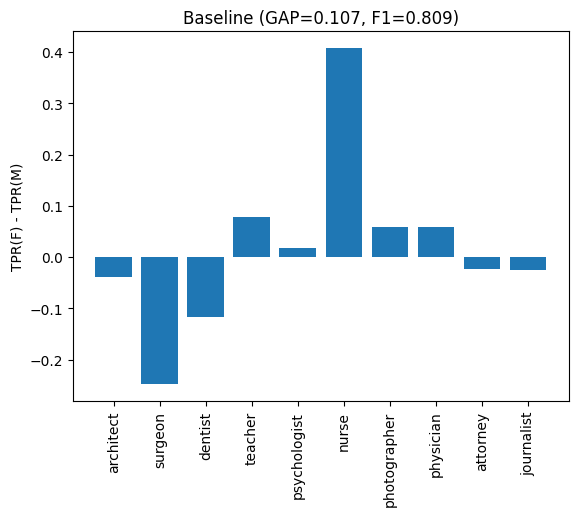

(0.808994159880673,
 0.7811528233523956,
 0.8447810879931801,
 0.10744832360076031,
 array([-0.03846154, -0.24825899, -0.11695906,  0.07857253,  0.01760949,
         0.40754484,  0.05904191,  0.05796175, -0.02421276, -0.02586037]))

In [168]:
debias_rebalance(emb_train, y_train, g_train, emb_val, y_val, g_val, emb_test, y_test, g_test, plot=True)

In [169]:
f1s = []
precs = []
recs = []
gaps = []
for i in range(10):
    f1, prec, rec, gap, _ = debias_rebalance(emb_train, y_train, g_train, emb_val, y_val, g_val, emb_test, y_test, g_test)
    precs.append(prec)
    recs.append(rec)
    f1s.append(f1)
    gaps.append(gap)

print("GAP = %.3f +/- %.3f" % (np.mean(gaps), np.std(gaps)))
print("F1 = %.3f +/- %.3f" % (np.mean(f1s), np.std(f1s)))
print("Precision = %.3f +/- %.3f" % (np.mean(precs), np.std(precs)))
print("Recall = %.3f +/- %.3f" % (np.mean(recs), np.std(recs)))

found only 20 of potential 32 subgroups in the data. only existing groups will be considered for resample
use class weights
stopping after 13 epochs with validation loss 0.965
return binary TPR GAP (group 1 - group 0):
mean abs TPR GAP: 0.103
found only 20 of potential 32 subgroups in the data. only existing groups will be considered for resample
use class weights
stopping after 16 epochs with validation loss 0.968
return binary TPR GAP (group 1 - group 0):
mean abs TPR GAP: 0.107
found only 20 of potential 32 subgroups in the data. only existing groups will be considered for resample
use class weights
stopping after 15 epochs with validation loss 0.966
return binary TPR GAP (group 1 - group 0):
mean abs TPR GAP: 0.095
found only 20 of potential 32 subgroups in the data. only existing groups will be considered for resample
use class weights
stopping after 12 epochs with validation loss 0.968
return binary TPR GAP (group 1 - group 0):
mean abs TPR GAP: 0.118
found only 20 of potential 3

In [170]:
f1s = []
precs = []
recs = []
gaps = []
for i in range(10):
    f1, prec, rec, gap, _ = debias_rebalance(emb_train, y_train, g_train, emb_val, y_val, g_val, emb_test, y_test, g_test, use_mlp=True)
    precs.append(prec)
    recs.append(rec)
    f1s.append(f1)
    gaps.append(gap)

print("GAP = %.3f +/- %.3f" % (np.mean(gaps), np.std(gaps)))
print("F1 = %.3f +/- %.3f" % (np.mean(f1s), np.std(f1s)))
print("Precision = %.3f +/- %.3f" % (np.mean(precs), np.std(precs)))
print("Recall = %.3f +/- %.3f" % (np.mean(recs), np.std(recs)))

found only 20 of potential 32 subgroups in the data. only existing groups will be considered for resample
use class weights
stopping after 11 epochs with validation loss 0.966
return binary TPR GAP (group 1 - group 0):
mean abs TPR GAP: 0.108
found only 20 of potential 32 subgroups in the data. only existing groups will be considered for resample
use class weights
stopping after 12 epochs with validation loss 0.967
return binary TPR GAP (group 1 - group 0):
mean abs TPR GAP: 0.095
found only 20 of potential 32 subgroups in the data. only existing groups will be considered for resample
use class weights
stopping after 12 epochs with validation loss 0.962
return binary TPR GAP (group 1 - group 0):
mean abs TPR GAP: 0.112
found only 20 of potential 32 subgroups in the data. only existing groups will be considered for resample
use class weights
stopping after 11 epochs with validation loss 0.963
return binary TPR GAP (group 1 - group 0):
mean abs TPR GAP: 0.100
found only 20 of potential 3

## Training on the rebalanced test set yields better generalization

### Debiasing with PIE: Re-balancing based on protected group concepts

In [213]:
_, concepts_train = pipeline.predict(emb_train, return_concepts=True, verbose=True)
_, concepts_val = pipeline.predict(emb_val, return_concepts=True, verbose=True)
pred_pie_base, concepts_test = pipeline.predict(emb_test, return_concepts=True, verbose=True)

100%|█████████████████████████████████████████| 40/40 [00:00<00:00, 1041.45it/s]


return binary TPR GAP (group 1 - group 0):
mean abs TPR GAP: 0.123


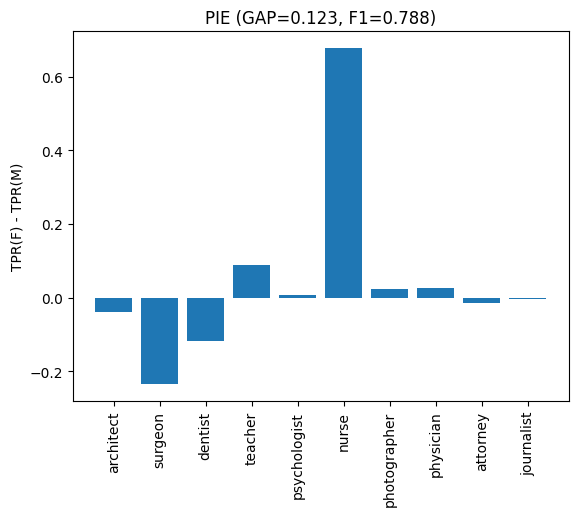

In [214]:
y_pred = (pred_pie_base >= 0.5).astype(int)
f1 = f1_score(y_test, y_pred, average='macro')
tpr_scores = compute_TPR_GAP(y_test, y_pred, g_test)
mean_gap = np.mean(np.abs(tpr_scores))
print("mean abs TPR GAP: %.3f" % mean_gap)
plot_tpr(tpr_scores, dataset.class_names, title='PIE (GAP=%.3f, F1=%.3f)' % (mean_gap, f1), ylabel='TPR(F) - TPR(M)')

In [215]:
f1s = []
precs = []
recs = []
gaps = []
for i in range(10):
    f1, prec, rec, gap, _ = train_baseline(concepts_train, y_train, c_train, concepts_val, y_val, g_val, concepts_test, y_test, g_test)
    precs.append(prec)
    recs.append(rec)
    f1s.append(f1)
    gaps.append(gap)

print("GAP = %.3f +/- %.3f" % (np.mean(gaps), np.std(gaps)))
print("F1 = %.3f +/- %.3f" % (np.mean(f1s), np.std(f1s)))
print("Precision = %.3f +/- %.3f" % (np.mean(precs), np.std(precs)))
print("Recall = %.3f +/- %.3f" % (np.mean(recs), np.std(recs)))

use class weights
stopping after 13 epochs with validation loss 0.966
return binary TPR GAP (group 1 - group 0):
mean abs TPR GAP: 0.134
use class weights
stopping after 14 epochs with validation loss 0.965
return binary TPR GAP (group 1 - group 0):
mean abs TPR GAP: 0.130
use class weights
stopping after 18 epochs with validation loss 0.964
return binary TPR GAP (group 1 - group 0):
mean abs TPR GAP: 0.130
use class weights
stopping after 18 epochs with validation loss 0.965
return binary TPR GAP (group 1 - group 0):
mean abs TPR GAP: 0.123
use class weights
stopping after 12 epochs with validation loss 0.965
return binary TPR GAP (group 1 - group 0):
mean abs TPR GAP: 0.137
use class weights
stopping after 19 epochs with validation loss 0.964
return binary TPR GAP (group 1 - group 0):
mean abs TPR GAP: 0.123
use class weights
stopping after 13 epochs with validation loss 0.965
return binary TPR GAP (group 1 - group 0):
mean abs TPR GAP: 0.129
use class weights
stopping after 13 epoch

In [216]:
f1s = []
precs = []
recs = []
gaps = []
for i in range(10):
    f1, prec, rec, gap, _ = train_baseline_mlp(concepts_train, y_train, c_train, concepts_val, y_val, g_val, concepts_test, y_test, g_test)
    precs.append(prec)
    recs.append(rec)
    f1s.append(f1)
    gaps.append(gap)

print("GAP = %.3f +/- %.3f" % (np.mean(gaps), np.std(gaps)))
print("F1 = %.3f +/- %.3f" % (np.mean(f1s), np.std(f1s)))
print("Precision = %.3f +/- %.3f" % (np.mean(precs), np.std(precs)))
print("Recall = %.3f +/- %.3f" % (np.mean(recs), np.std(recs)))

use class weights
stopping after 14 epochs with validation loss 0.965
return binary TPR GAP (group 1 - group 0):
mean abs TPR GAP: 0.132
use class weights
stopping after 15 epochs with validation loss 0.964
return binary TPR GAP (group 1 - group 0):
mean abs TPR GAP: 0.123
use class weights
stopping after 15 epochs with validation loss 0.965
return binary TPR GAP (group 1 - group 0):
mean abs TPR GAP: 0.132
use class weights
stopping after 14 epochs with validation loss 0.965
return binary TPR GAP (group 1 - group 0):
mean abs TPR GAP: 0.130
use class weights
stopping after 13 epochs with validation loss 0.963
return binary TPR GAP (group 1 - group 0):
mean abs TPR GAP: 0.136
use class weights
stopping after 12 epochs with validation loss 0.991
return binary TPR GAP (group 1 - group 0):
mean abs TPR GAP: 0.129
use class weights


/home/saschroeder/anaconda3/envs/pie/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


stopping after 12 epochs with validation loss 0.965
return binary TPR GAP (group 1 - group 0):
mean abs TPR GAP: 0.139
use class weights
stopping after 15 epochs with validation loss 0.967
return binary TPR GAP (group 1 - group 0):
mean abs TPR GAP: 0.131
use class weights
stopping after 11 epochs with validation loss 0.964
return binary TPR GAP (group 1 - group 0):
mean abs TPR GAP: 0.132
use class weights
stopping after 14 epochs with validation loss 0.964
return binary TPR GAP (group 1 - group 0):
mean abs TPR GAP: 0.145
GAP = 0.133 +/- 0.006
F1 = 0.822 +/- 0.030
Precision = 0.803 +/- 0.031
Recall = 0.843 +/- 0.029


In [217]:
c_train = (concepts_train >= 0).astype(int)[:, [mid_pie, fid_pie]]
c_val = (concepts_val >= 0).astype(int)[:, [mid_pie, fid_pie]]

#### PIE + Rebalance

found only 29 of potential 32 subgroups in the data. only existing groups will be considered for resample
use class weights
stopping after 18 epochs with validation loss 0.978
return binary TPR GAP (group 1 - group 0):
mean abs TPR GAP: 0.113


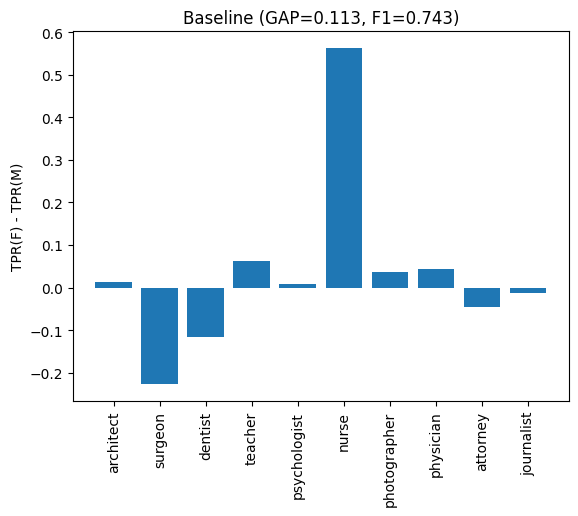

(0.7428464981395365,
 0.6975943560409072,
 0.8157390480640949,
 0.11274847805746106,
 array([ 0.01238592, -0.22680218, -0.11695906,  0.06286572,  0.00821168,
         0.56215213,  0.03776532,  0.04307889, -0.04503182, -0.01223206]))

In [218]:
debias_rebalance(concepts_train, y_train, c_train, concepts_val, y_val, g_val, concepts_test, y_test, g_test, plot=True)

In [219]:
f1s = []
precs = []
recs = []
gaps = []
for i in range(10):
    f1, prec, rec, gap, _ = debias_rebalance(concepts_train, y_train, c_train, concepts_val, y_val, g_val, concepts_test, y_test, g_test)
    precs.append(prec)
    recs.append(rec)
    f1s.append(f1)
    gaps.append(gap)

print("GAP = %.3f +/- %.3f" % (np.mean(gaps), np.std(gaps)))
print("F1 = %.3f +/- %.3f" % (np.mean(f1s), np.std(f1s)))
print("Precision = %.3f +/- %.3f" % (np.mean(precs), np.std(precs)))
print("Recall = %.3f +/- %.3f" % (np.mean(recs), np.std(recs)))

found only 29 of potential 32 subgroups in the data. only existing groups will be considered for resample
use class weights
stopping after 16 epochs with validation loss 0.979
return binary TPR GAP (group 1 - group 0):
mean abs TPR GAP: 0.099
found only 29 of potential 32 subgroups in the data. only existing groups will be considered for resample
use class weights
stopping after 24 epochs with validation loss 0.976
return binary TPR GAP (group 1 - group 0):
mean abs TPR GAP: 0.106
found only 29 of potential 32 subgroups in the data. only existing groups will be considered for resample
use class weights
stopping after 22 epochs with validation loss 0.975
return binary TPR GAP (group 1 - group 0):
mean abs TPR GAP: 0.093
found only 29 of potential 32 subgroups in the data. only existing groups will be considered for resample
use class weights
stopping after 19 epochs with validation loss 0.976
return binary TPR GAP (group 1 - group 0):
mean abs TPR GAP: 0.111
found only 29 of potential 3

In [220]:
f1s = []
precs = []
recs = []
gaps = []
for i in range(10):
    f1, prec, rec, gap, _ = debias_rebalance(concepts_train, y_train, c_train, concepts_val, y_val, g_val, concepts_test, y_test, g_test, use_mlp=True)
    precs.append(prec)
    recs.append(rec)
    f1s.append(f1)
    gaps.append(gap)

print("GAP = %.3f +/- %.3f" % (np.mean(gaps), np.std(gaps)))
print("F1 = %.3f +/- %.3f" % (np.mean(f1s), np.std(f1s)))
print("Precision = %.3f +/- %.3f" % (np.mean(precs), np.std(precs)))
print("Recall = %.3f +/- %.3f" % (np.mean(recs), np.std(recs)))

found only 29 of potential 32 subgroups in the data. only existing groups will be considered for resample
use class weights
stopping after 14 epochs with validation loss 1.025
return binary TPR GAP (group 1 - group 0):
mean abs TPR GAP: 0.088
found only 29 of potential 32 subgroups in the data. only existing groups will be considered for resample
use class weights


/home/saschroeder/anaconda3/envs/pie/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


stopping after 14 epochs with validation loss 1.001
return binary TPR GAP (group 1 - group 0):
mean abs TPR GAP: 0.110
found only 29 of potential 32 subgroups in the data. only existing groups will be considered for resample
use class weights


/home/saschroeder/anaconda3/envs/pie/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


stopping after 13 epochs with validation loss 0.975
return binary TPR GAP (group 1 - group 0):
mean abs TPR GAP: 0.099
found only 29 of potential 32 subgroups in the data. only existing groups will be considered for resample
use class weights
stopping after 15 epochs with validation loss 0.999
return binary TPR GAP (group 1 - group 0):
mean abs TPR GAP: 0.090
found only 29 of potential 32 subgroups in the data. only existing groups will be considered for resample
use class weights


/home/saschroeder/anaconda3/envs/pie/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


stopping after 13 epochs with validation loss 1.024
return binary TPR GAP (group 1 - group 0):
mean abs TPR GAP: 0.095
found only 29 of potential 32 subgroups in the data. only existing groups will be considered for resample
use class weights


/home/saschroeder/anaconda3/envs/pie/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


stopping after 13 epochs with validation loss 1.025
return binary TPR GAP (group 1 - group 0):
mean abs TPR GAP: 0.107
found only 29 of potential 32 subgroups in the data. only existing groups will be considered for resample
use class weights


/home/saschroeder/anaconda3/envs/pie/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


stopping after 14 epochs with validation loss 1.003
return binary TPR GAP (group 1 - group 0):
mean abs TPR GAP: 0.097
found only 29 of potential 32 subgroups in the data. only existing groups will be considered for resample
use class weights


/home/saschroeder/anaconda3/envs/pie/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


stopping after 13 epochs with validation loss 1.023
return binary TPR GAP (group 1 - group 0):
mean abs TPR GAP: 0.107
found only 29 of potential 32 subgroups in the data. only existing groups will be considered for resample
use class weights


/home/saschroeder/anaconda3/envs/pie/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


stopping after 13 epochs with validation loss 0.976
return binary TPR GAP (group 1 - group 0):
mean abs TPR GAP: 0.121
found only 29 of potential 32 subgroups in the data. only existing groups will be considered for resample
use class weights
stopping after 12 epochs with validation loss 1.023
return binary TPR GAP (group 1 - group 0):
mean abs TPR GAP: 0.099
GAP = 0.101 +/- 0.009
F1 = 0.681 +/- 0.065
Precision = 0.670 +/- 0.068
Recall = 0.703 +/- 0.063


/home/saschroeder/anaconda3/envs/pie/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


#### PIE + INLP

iteration: 3, accuracy: 0.5669216061185468: 100%|█| 4/4 [00:01<00:00,  3.28it/s]


time: 1.3063673973083496
use class weights
stopping after 22 epochs with validation loss 0.969
return binary TPR GAP (group 1 - group 0):
mean abs TPR GAP: 0.062


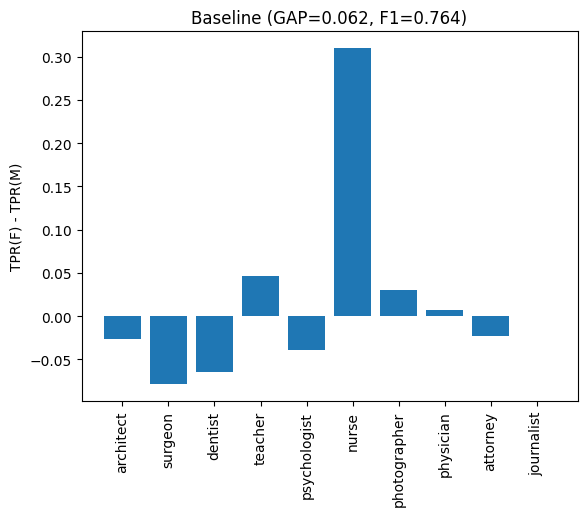

(0.764161168796824,
 0.7024483224303746,
 0.8433180427752258,
 0.06243635939551936,
 array([-0.02607562, -0.07867495, -0.06432749,  0.04592701, -0.03868613,
         0.30983302,  0.03028906,  0.00715075, -0.02280959,  0.00058997]))

In [221]:
debias_inlp(concepts_train, y_train, c_train, concepts_val, y_val, c_val, concepts_test, y_test, g_test, n_iter=4, clf_type="svm", plot=True)

In [222]:
f1s = []
precs = []
recs = []
gaps = []
for i in range(10):
    f1, prec, rec, gap, _ = debias_inlp(concepts_train, y_train, c_train, concepts_val, y_val, c_val, concepts_test, y_test, g_test, n_iter=4, clf_type="svm")
    precs.append(prec)
    recs.append(rec)
    f1s.append(f1)
    gaps.append(gap)

print("GAP = %.3f +/- %.3f" % (np.mean(gaps), np.std(gaps)))
print("F1 = %.3f +/- %.3f" % (np.mean(f1s), np.std(f1s)))
print("Precision = %.3f +/- %.3f" % (np.mean(precs), np.std(precs)))
print("Recall = %.3f +/- %.3f" % (np.mean(recs), np.std(recs)))

iteration: 3, accuracy: 0.5669216061185468: 100%|█| 4/4 [00:01<00:00,  3.33it/s]


time: 1.2807915210723877
use class weights
stopping after 13 epochs with validation loss 0.968
return binary TPR GAP (group 1 - group 0):
mean abs TPR GAP: 0.064


iteration: 3, accuracy: 0.5669216061185468: 100%|█| 4/4 [00:01<00:00,  3.51it/s]


time: 1.2177152633666992
use class weights
stopping after 23 epochs with validation loss 0.970
return binary TPR GAP (group 1 - group 0):
mean abs TPR GAP: 0.071


iteration: 3, accuracy: 0.5669216061185468: 100%|█| 4/4 [00:01<00:00,  3.42it/s]


time: 1.2508585453033447
use class weights
stopping after 25 epochs with validation loss 0.969
return binary TPR GAP (group 1 - group 0):
mean abs TPR GAP: 0.062


iteration: 3, accuracy: 0.5669216061185468: 100%|█| 4/4 [00:01<00:00,  3.34it/s]


time: 1.2772061824798584
use class weights
stopping after 24 epochs with validation loss 0.969
return binary TPR GAP (group 1 - group 0):
mean abs TPR GAP: 0.053


iteration: 3, accuracy: 0.5669216061185468: 100%|█| 4/4 [00:01<00:00,  3.63it/s]


time: 1.180567979812622
use class weights
stopping after 19 epochs with validation loss 0.969
return binary TPR GAP (group 1 - group 0):
mean abs TPR GAP: 0.068


iteration: 3, accuracy: 0.5669216061185468: 100%|█| 4/4 [00:01<00:00,  3.76it/s]


time: 1.1414496898651123
use class weights
stopping after 16 epochs with validation loss 0.970
return binary TPR GAP (group 1 - group 0):
mean abs TPR GAP: 0.075


iteration: 3, accuracy: 0.5669216061185468: 100%|█| 4/4 [00:01<00:00,  3.36it/s]


time: 1.2674610614776611
use class weights
stopping after 22 epochs with validation loss 0.969
return binary TPR GAP (group 1 - group 0):
mean abs TPR GAP: 0.059


iteration: 3, accuracy: 0.5669216061185468: 100%|█| 4/4 [00:01<00:00,  3.42it/s]


time: 1.24395751953125
use class weights
stopping after 20 epochs with validation loss 0.970
return binary TPR GAP (group 1 - group 0):
mean abs TPR GAP: 0.073


iteration: 3, accuracy: 0.5669216061185468: 100%|█| 4/4 [00:01<00:00,  3.09it/s]


time: 1.3807132244110107
use class weights
stopping after 18 epochs with validation loss 0.968
return binary TPR GAP (group 1 - group 0):
mean abs TPR GAP: 0.081


iteration: 3, accuracy: 0.5669216061185468: 100%|█| 4/4 [00:01<00:00,  3.36it/s]


time: 1.2656073570251465
use class weights
stopping after 23 epochs with validation loss 0.970
return binary TPR GAP (group 1 - group 0):
mean abs TPR GAP: 0.069
GAP = 0.067 +/- 0.008
F1 = 0.769 +/- 0.005
Precision = 0.713 +/- 0.011
Recall = 0.839 +/- 0.004


In [223]:
f1s = []
precs = []
recs = []
gaps = []
for i in range(10):
    f1, prec, rec, gap, _ = debias_inlp(concepts_train, y_train, c_train, concepts_val, y_val, c_val, concepts_test, y_test, g_test, n_iter=4, clf_type="svm", use_mlp=True)
    precs.append(prec)
    recs.append(rec)
    f1s.append(f1)
    gaps.append(gap)

print("GAP = %.3f +/- %.3f" % (np.mean(gaps), np.std(gaps)))
print("F1 = %.3f +/- %.3f" % (np.mean(f1s), np.std(f1s)))
print("Precision = %.3f +/- %.3f" % (np.mean(precs), np.std(precs)))
print("Recall = %.3f +/- %.3f" % (np.mean(recs), np.std(recs)))

iteration: 3, accuracy: 0.5669216061185468: 100%|█| 4/4 [00:01<00:00,  3.70it/s]


time: 1.1641845703125
use class weights
stopping after 14 epochs with validation loss 0.970
return binary TPR GAP (group 1 - group 0):
mean abs TPR GAP: 0.089


iteration: 3, accuracy: 0.5669216061185468: 100%|█| 4/4 [00:01<00:00,  3.73it/s]


time: 1.1530978679656982
use class weights
stopping after 23 epochs with validation loss 0.971
return binary TPR GAP (group 1 - group 0):
mean abs TPR GAP: 0.099


iteration: 3, accuracy: 0.5669216061185468: 100%|█| 4/4 [00:01<00:00,  3.42it/s]


time: 1.2482938766479492
use class weights
stopping after 13 epochs with validation loss 0.968
return binary TPR GAP (group 1 - group 0):
mean abs TPR GAP: 0.101


iteration: 3, accuracy: 0.5669216061185468: 100%|█| 4/4 [00:01<00:00,  3.29it/s]


time: 1.3004815578460693
use class weights
stopping after 14 epochs with validation loss 0.970
return binary TPR GAP (group 1 - group 0):
mean abs TPR GAP: 0.091


iteration: 3, accuracy: 0.5669216061185468: 100%|█| 4/4 [00:01<00:00,  3.46it/s]


time: 1.2342422008514404
use class weights
stopping after 15 epochs with validation loss 0.971
return binary TPR GAP (group 1 - group 0):
mean abs TPR GAP: 0.100


iteration: 3, accuracy: 0.5669216061185468: 100%|█| 4/4 [00:01<00:00,  3.24it/s]


time: 1.3109536170959473
use class weights
stopping after 14 epochs with validation loss 0.969
return binary TPR GAP (group 1 - group 0):
mean abs TPR GAP: 0.080


iteration: 3, accuracy: 0.5669216061185468: 100%|█| 4/4 [00:01<00:00,  3.55it/s]


time: 1.200836181640625
use class weights
stopping after 13 epochs with validation loss 0.970
return binary TPR GAP (group 1 - group 0):
mean abs TPR GAP: 0.083


iteration: 3, accuracy: 0.5669216061185468: 100%|█| 4/4 [00:01<00:00,  3.38it/s]


time: 1.2709052562713623
use class weights
stopping after 14 epochs with validation loss 0.968
return binary TPR GAP (group 1 - group 0):
mean abs TPR GAP: 0.084


iteration: 3, accuracy: 0.5669216061185468: 100%|█| 4/4 [00:01<00:00,  3.33it/s]


time: 1.2934792041778564
use class weights
stopping after 15 epochs with validation loss 0.969
return binary TPR GAP (group 1 - group 0):
mean abs TPR GAP: 0.084


iteration: 3, accuracy: 0.5669216061185468: 100%|█| 4/4 [00:01<00:00,  3.26it/s]


time: 1.3094613552093506
use class weights
stopping after 13 epochs with validation loss 0.999
return binary TPR GAP (group 1 - group 0):
mean abs TPR GAP: 0.098
GAP = 0.091 +/- 0.008
F1 = 0.803 +/- 0.028
Precision = 0.792 +/- 0.027
Recall = 0.817 +/- 0.030


/home/saschroeder/anaconda3/envs/pie/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


#### PIE: Protected concepts + other concepts cleaned with INLP

In [224]:
len(pipeline.group_lbl)

38

#### PIE + Counterfactuals

In [236]:
from torch.utils.data import TensorDataset, DataLoader
from salsa.SaLSA import SaLSA

class FairCFWrapper:
    def __init__(self, model: torch.nn.Module, batch_size: int, class_weights=None, criterion=torch.nn.BCEWithLogitsLoss,
                 optimizer=torch.optim.RMSprop, lr=1e-3):
        self.model = model
        self.batch_size = batch_size
        self.class_weights = class_weights
        self.lambda_fair = 0.5
        if class_weights is not None:
            print("use class weights")
            class_weights = torch.tensor(class_weights)
            if torch.cuda.is_available():
                class_weights = class_weights.to('cuda')
            self.criterion = criterion(pos_weight=class_weights)
        else:
            self.criterion = criterion()

        if optimizer is SaLSA:
            self.optimizer = optimizer(self.model.parameters())
        else:
            assert lr is not None
            self.optimizer = optimizer(self.model.parameters(), lr=lr)

    def fit_early_stopping(self, X_train: np.ndarray, y_train: np.ndarray, X_val: np.ndarray, y_val: np.ndarray,
                           ids_protec: list, max_epochs: int, delta: float = 0.0, patience: int = 10, verbose: bool = False):
        assert max_epochs > 2
        best_loss = 999
        counter = 0
        final_epochs = max_epochs
        patience = min(patience, max_epochs - 2)  # otherwise early stopping doesn't make sense
        if verbose:
            print("run early stopping with delta=%f and patience=%i" % (delta, patience))

        y_val = torch.from_numpy(y_val)

        for i in range(max_epochs):
            self.fit(X=X_train, y=y_train, ids_protec=ids_protec, epochs=1, verbose=verbose)
            pred = self.predict(X_val, return_tensors=True)

            if torch.cuda.is_available():
                y_val = y_val.to('cuda')
                pred = pred.to('cuda')

            val_loss = self.criterion(pred, y_val)

            if torch.cuda.is_available():
                pred = pred.to('cpu')
                y_val = y_val.to('cpu')
                val_loss = val_loss.to('cpu')

            if val_loss < best_loss - delta:
                best_loss = val_loss
                counter = 0
            else:
                counter += 1

            if counter == patience:
                final_epochs = i
                break

        if final_epochs < max_epochs:
            print("stopping after %i epochs with validation loss %.3f" % (i, val_loss))
        return final_epochs

    def fit(self, X, y, ids_protec, epochs, verbose=False):
        X_cf = X.copy()
        X_cf[:, ids_protec] = - X[:, ids_protec]
        dataset = TensorDataset(torch.tensor(X), torch.tensor(y), torch.tensor(X_cf))
        loader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True)

        for epoch in range(epochs):
            if verbose:
                loop = tqdm(loader, leave=True)
            else:
                loop = loader

            for batch in loop:
                self.optimizer.zero_grad()

                batch_x = batch[0]
                batch_y = batch[1]
                batch_cf = batch[2]
                if torch.cuda.is_available():
                    batch_x = batch_x.to('cuda')
                    batch_y = batch_y.to('cuda')
                    batch_cf = batch_cf.to('cuda')

                def closure(backwards=False):
                    batch_pred = self.model.forward(batch_x)
                    batch_pred_cf = self.model.forward(batch_cf)
                    loss_pred = self.criterion(batch_pred, batch_y)
                    loss_fair = torch.mean((batch_pred - batch_pred_cf) ** 2)
                    loss = loss_pred + self.lambda_fair * loss_fair
                    if backwards:
                        loss.backward()

                    batch_pred.to('cpu')
                    del batch_pred

                    return loss

                loss = self.optimizer.step(closure=closure)

                if verbose:
                    loop.set_description(f'Epoch {epoch}')
                    loop.set_postfix(loss=loss.item())

                loss = loss.detach().item()

                if torch.cuda.is_available():
                    batch_x = batch_x.to('cpu')
                    batch_y = batch_y.to('cpu')
                    batch_cf = batch_cf.to('cpu')

                del batch_x
                del batch_y
        torch.cuda.empty_cache()

    def predict(self, X, verbose=False, return_tensors=False):
        dataset = TensorDataset(torch.tensor(X))
        loader = DataLoader(dataset, batch_size=self.batch_size, shuffle=False)
        predictions = []

        if verbose:
            loop = tqdm(loader, leave=True)
        else:
            loop = loader

        for batch in loop:
            if torch.cuda.is_available():
                batch_x = batch[0].to('cuda')

            batch_pred = self.model.forward(batch_x)

            if torch.cuda.is_available():
                batch_pred = batch_pred.to('cpu')
                batch_x = batch_x.to('cpu')

            if return_tensors:
                predictions.append(batch_pred.detach())
            else:
                batch_pred = batch_pred.detach().numpy()
                predictions.append(batch_pred)

            del batch_x

        torch.cuda.empty_cache()

        if return_tensors:
            predictions = torch.vstack(predictions)
        else:
            predictions = np.vstack(predictions)

        return predictions

In [237]:
def train_cf(emb_train, y_train, g_train, emb_val, y_val, g_val, emb_test, y_test, g_test, ids_cf, use_mlp=False, plot=False):
    if use_mlp:
        clf_base = models.MLP2Layer(input_size=emb_test.shape[1], hidden_size=emb_test.shape[1], output_size=dataset.n_classes)
    else:
        clf_base = models.LinearClassifier(input_size=emb_test.shape[1], output_size=dataset.n_classes)
        
    wrapper = FairCFWrapper(clf_base, batch_size=64, class_weights=cw, criterion=torch.nn.BCEWithLogitsLoss, optimizer=SaLSA)
    wrapper.fit_early_stopping(emb_train, y_train, emb_val, y_val, ids_cf, max_epochs=50, delta=0.0, patience=10, verbose=False)
    pred = wrapper.predict(emb_test)
    y_pred = (pred >= 0.5).astype(int)
    
    f1 = f1_score(y_test, y_pred, average='macro')
    rec = recall_score(y_test, y_pred, average='macro')
    prec = precision_score(y_test, y_pred, average='macro')
    tpr_scores = compute_TPR_GAP(y_test, y_pred, g_test)
    mean_gap = np.mean(np.abs(tpr_scores))
    print("mean abs TPR GAP: %.3f" % mean_gap)

    if plot:
        plot_tpr(tpr_scores, dataset.class_names, 'Baseline (GAP=%.3f, F1=%.3f)' % (mean_gap, f1), ylabel='TPR(F) - TPR(M)')

    return f1, prec, rec, mean_gap, tpr_scores

use class weights
stopping after 16 epochs with validation loss 0.966
return binary TPR GAP (group 1 - group 0):
mean abs TPR GAP: 0.120


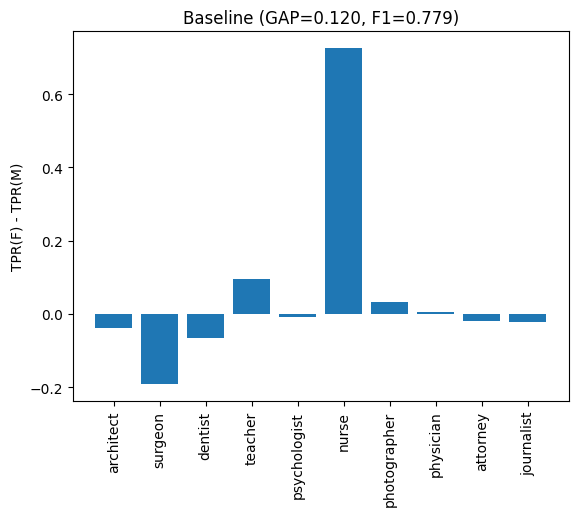

(0.77876059632092,
 0.709921470130869,
 0.8699334091228593,
 0.12006559177620155,
 array([-0.03846154, -0.1916055 , -0.06432749,  0.09516477, -0.00739051,
         0.72541744,  0.03364314,  0.00488344, -0.01820852, -0.02155359]))

In [238]:
train_cf(concepts_train, y_train, g_train, concepts_val, y_val, g_val, concepts_test, y_test, g_test, [mid_pie, fid_pie], use_mlp=False, plot=True)

In [241]:
f1s = []
precs = []
recs = []
gaps = []
for i in range(10):
    f1, prec, rec, gap, _ = train_cf(concepts_train, y_train, g_train, concepts_val, y_val, g_val, concepts_test, y_test, g_test, [mid_pie, fid_pie], use_mlp=False)
    precs.append(prec)
    recs.append(rec)
    f1s.append(f1)
    gaps.append(gap)

print("GAP = %.3f +/- %.3f" % (np.mean(gaps), np.std(gaps)))
print("F1 = %.3f +/- %.3f" % (np.mean(f1s), np.std(f1s)))
print("Precision = %.3f +/- %.3f" % (np.mean(precs), np.std(precs)))
print("Recall = %.3f +/- %.3f" % (np.mean(recs), np.std(recs)))

use class weights
stopping after 14 epochs with validation loss 0.965
return binary TPR GAP (group 1 - group 0):
mean abs TPR GAP: 0.129
use class weights
stopping after 15 epochs with validation loss 0.965
return binary TPR GAP (group 1 - group 0):
mean abs TPR GAP: 0.136
use class weights
stopping after 16 epochs with validation loss 0.966
return binary TPR GAP (group 1 - group 0):
mean abs TPR GAP: 0.115
use class weights
stopping after 18 epochs with validation loss 0.966
return binary TPR GAP (group 1 - group 0):
mean abs TPR GAP: 0.114
use class weights
stopping after 16 epochs with validation loss 0.965
return binary TPR GAP (group 1 - group 0):
mean abs TPR GAP: 0.119
use class weights
stopping after 15 epochs with validation loss 0.969
return binary TPR GAP (group 1 - group 0):
mean abs TPR GAP: 0.116
use class weights
stopping after 21 epochs with validation loss 0.964
return binary TPR GAP (group 1 - group 0):
mean abs TPR GAP: 0.122
use class weights
stopping after 16 epoch